In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
###2.7.1 标准化数值特征
# Load some data
(x_train, y_train), _ = keras.datasets.cifar10.load_data()
x_train = x_train.reshape((len(x_train), -1))
input_shape = x_train.shape[1:]
classes = 10

# Create a Normalization layer and set its internal state using the training data
normalizer = layers.Normalization()
normalizer.adapt(x_train)

# Create a model that include the normalization layer
inputs = keras.Input(shape=input_shape)
x = normalizer(inputs)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# Train the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
model.fit(x_train, y_train)




1563/1563 [==============================] - 6s 3ms/step - loss: 2.1259


In [7]:
x_train[:,-1]

array([ 72, 144,  84, ...,  50, 171, 161], dtype=uint8)

In [11]:
normalizer(x_train)[:,-1]

<tf.Tensor: shape=(50000,), dtype=float32, numpy=
array([-0.6414034 ,  0.44823936, -0.45979625, ..., -0.97434974,
        0.85685533,  0.7055161 ], dtype=float32)>

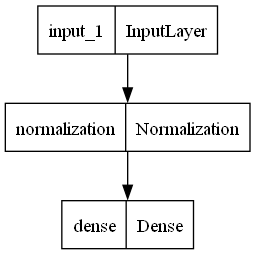

In [12]:
#您还可以将模型绘制为计算图：
keras.utils.plot_model(model, "my_first_model.png")  #normalizer也是网络的一层

In [16]:
### 2.7.2 通过单热编码对字符串分类特征进行编码
# Define some toy data
data = tf.constant([["a"], ["b"], ["c"], ["b"], ["c"], ["a"]])

# Use StringLookup to build an index of the feature values and encode output.
lookup = layers.StringLookup(output_mode="one_hot")
lookup.adapt(data)

# Convert new test data (which includes unknown feature values)
test_data = tf.constant([["a"], ["b"], ["c"], ["d"], ["e"], [""]])
encoded_data = lookup(test_data)  #请注意，此处的索引 0 保留用于词汇表外值（adapt()期间未看到的值）。
encoded_data

<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)>

In [19]:
### 2.7.3 通过单热编码对整数分类特征进行编码 - 重要
# Define some toy data
data = tf.constant([[10], [20], [20], [10], [30], [0]])

# Use IntegerLookup to build an index of the feature values and encode output.
lookup = layers.IntegerLookup(output_mode="one_hot")
lookup.adapt(data)

# Convert new test data (which includes unknown feature values)
test_data = tf.constant([[10], [10], [20], [50], [60], [0]])
encoded_data = lookup(test_data) #请注意，索引 0 是为缺失值（应将其指定为值）保留的 0），索引 1 保留用于词汇表外值（adapt()期间未看到的值））。
encoded_data

<tf.Tensor: shape=(6, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [21]:
### 2.7.4 将哈希技巧应用于整数分类特征
#如果您有一个可以采用许多不同值的分类特征（按 1e4 或更高），其中每个值在数据中仅出现几次， 对特征值进行索引和单热编码变得不切实际且无效。
# 相反，应用“哈希技巧”可能是一个好主意：将值哈希到向量 固定大小。这样可以使功能空间的大小保持可管理，并消除了需求 用于显式索引。
# Sample data: 10,000 random integers with values between 0 and 100,000
data = np.random.randint(0, 100000, size=(10000, 1))

# Use the Hashing layer to hash the values to the range [0, 64]
hasher = layers.Hashing(num_bins=64, salt=1337)

# Use the CategoryEncoding layer to multi-hot encode the hashed values
encoder = layers.CategoryEncoding(num_tokens=64, output_mode="multi_hot")
encoded_data = encoder(hasher(data))
encoded_data.shape

TensorShape([10000, 64])

In [23]:
encoded_data[-1]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [25]:
###<补充> 2.7.5 将hash技巧用于字符串分类特征
import tensorflow as tf  
  
# 创建一个字符串张量  
string_tensor = tf.constant(["apple", "banana", "cherry"])  
  
# 设置哈希桶的数量  
num_buckets = 10  
  
# 对字符串进行哈希  
hashed_tensor = tf.strings.to_hash_bucket(string_tensor, num_buckets)  
  
# 输出哈希值  
hashed_tensor

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 7, 8], dtype=int64)>

In [ ]:
### 总结
#1. 是单独在tf中进行特征处理，还是用hadoop等预处理好，根据实际数据决定，数据量较大时推荐hadoop预处理好再训练；
#2. 特征hash可用MurmurHash，是一种非加密型哈希函数，适用于一般的哈希检索操作，具有较高的运算性能和较低的碰撞率。